# Let's train a classifier

In [17]:
import os
# os.system("pip install foolbox")
# os.system("pip install torchmetrics")
# os.system("pip install neptune")
# os.system("pip install pandas")
# os.system("pip install torchvision")
# os.system("CUDA_LAUNCH_BLOCKING=1")
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet50, densenet121, densenet169, ResNet18_Weights, ResNet34_Weights, ResNet50_Weights, DenseNet121_Weights, DenseNet169_Weights

import time

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import neptune
from rtpt import RTPT
import foolbox as fb
from foolbox import PyTorchModel
from foolbox.attacks import L2AdditiveGaussianNoiseAttack, LinfFastGradientAttack, LinfDeepFoolAttack
from foolbox.criteria import Misclassification
import eagerpy as ep
import random

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

torch.manual_seed(1)

In [18]:
# choose experiment
size_train = 10000
exp_setups = ["only white", "augmented", "original"]
# is_celeba = False
exp = 2

# set noise attack parameters
smallest_eps = 0
biggest_eps = 1e-2 # 5e-3 #2e-3
eps_steps = 21
eps_attack = [] #np.linspace(start=smallest_eps, stop=biggest_eps, num=eps_steps)#[] #[2e-4, 1e-4, 5e-5] #[1e-5, 2e-5, 5e-5]# #[5e-5, 1e-4, 5e-4] #[2e-4, 1e-4, 5e-5] #Gaussian: approx. 20, FGSM: approx. 5e-5
do_noise_attack = len(eps_attack) > 0
gaussian_attack = biggest_eps > 1 and do_noise_attack

# set occlusion attack parameters
occ_during_train = True
occ_mean_train = 0.5
smallest_occ = 0
biggest_occ = 1
occ_steps = 51
occ_means = np.linspace(start=smallest_occ, stop=biggest_occ, num=occ_steps) # 0.3[0] #0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8
occ_means = np.round(occ_means, 4)
occ_during_val = len(occ_means) > 1

# set general hyperparameters
model_desc = "resnet34" #densenet169  resnet34
device = 'cuda:14'
lr = 1e-4
num_epochs = 50
pretrained = True
feat_size = (256, 256)
bs_train = 128
bs_val = 128
bs_test = 128
scheduler_step_size = 3
scheduler_gamma = 0.9

# save/load checkpoints
ckpt_dir = "ckpts/"
load_ckpt = True
exp_num = 127 + exp #503 + exp # 353 406
after_epoch = 50
# ckpt_load_path = f"{ckpt_dir}AUGPRE-{exp_num}_{after_epoch}_epochs.pt"
ckpt_load_path = f"{ckpt_dir}EX-{exp_num}_{after_epoch}_epochs.pt"
save_ckpt_after_epochs = [50, 100]#92, 94, 96, 98, 

# paths
train_only_white_csv = "train_exp_0.csv"
train_aug_csv = "train_exp_1.csv"
train_balanced_csv = "train_exp_2.csv"
train_dir = "combined_dataset/train/10k/"
val_dir = "combined_dataset/val/5_5k/"
val_csv = "val.csv"
test_dir = "combined_dataset/test/5_5k/"
test_csv = "test.csv"
occ_dir = "occlusions/uniformly_distributed/"


races = ["Black", "Indian", "Latino", "Middle Eastern", "Southeast Asian", "East Asian", "White", "No race"]
# ignored_attributes = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Pale_Skin"]

In [19]:
class CombinedDataset(Dataset):
    """Dataset for loading FairFace and ImageNet images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=None)
        # print(df.head())
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df["Image_Name"].values
        self.races = df["Race"].replace("Latino_Hispanic", "Latino").replace(np.nan, "No race").values
        self.y = df["Face"] #df["Gender"].replace("Male", 1).replace("Female", 0).values
        # print(len(self.races), self.races)
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        gt_race = self.races[index]
        # print(label, gt_race)
        return img, label, gt_race

    def __len__(self):
        return self.y.shape[0]

In [20]:
# create datasets based on current experiment
num_workers = 6

# do normalization here when not performing attack
# if do_attack:
# custom_transform = transforms.Compose([transforms.Resize(feat_size),
#                                     transforms.ToTensor()])
# else:
custom_transform = transforms.Compose([transforms.Resize(feat_size),
                                    transforms.ToTensor()])#,
                                    # transforms.RandomHorizontalFlip()]) #,
                                    # transforms.Normalize(mean=(0.421, 0.337, 0.301), std=([0.290, 0.269, 0.264]))])
                                    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])


# training dataset
if exp_setups[exp] == "augmented":
    train_csv = train_aug_csv
else:
    if exp_setups[exp] == "only white":
        train_csv = train_only_white_csv
    else:
        train_csv = train_balanced_csv

train_dataset = CombinedDataset(csv_path=train_dir + train_csv,
                                img_dir=train_dir,
                                transform=custom_transform)


# validation dataset
val_dataset = CombinedDataset(csv_path=val_dir + val_csv,
                                img_dir=val_dir,
                                transform=custom_transform)



# test datasets
test_dataset = CombinedDataset(csv_path=test_dir + test_csv,
                                img_dir=test_dir,
                                transform=custom_transform)


# create dataloaders on these datasets
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=bs_train,
                          shuffle=True,
                          num_workers=num_workers)

val_loader = DataLoader(dataset=val_dataset,
                          batch_size=bs_val,
                          shuffle=False,
                          num_workers=num_workers)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=bs_test,
                          shuffle=False,
                          num_workers=num_workers)

In [21]:
# # Calculate the mean and standard deviation per channel
# channel_means = torch.zeros(3)
# channel_stds = torch.zeros(3)
# total_samples = 0

# for batch in train_loader:
#     images, _, _ = batch
#     batch_size = images.size(0)
#     total_samples += batch_size
#     channel_sums = torch.sum(torch.sum(images, dim=2), dim=2)
#     channel_means += torch.sum(channel_sums, dim=0)
#     channel_stds += torch.sum(torch.sum(torch.sum(images ** 2, dim=2), dim=2), dim=0)

# channel_means /= total_samples * images.size(2) * images.size(3)
# channel_stds /= total_samples * images.size(2) * images.size(3)
# # channel_stds = torch.sqrt(channel_stds - channel_means ** 2)

# print("Mean per channel:", channel_means.tolist())
# # print("Standard Deviation per channel:", channel_stds.tolist())

# # Define the known means per channel
# channel_means = [0,0,0]

# # Calculate the standard deviation per channel
# channel_stds = torch.zeros(3)
# total_samples = 0

# for batch in train_loader:
#     images, _, _ = batch
#     batch_size = images.size(0)
#     total_samples += batch_size
#     channel_sums = torch.sum(torch.sum(images, dim=2), dim=2)
#     channel_stds += torch.sum(torch.sum(torch.sum((images - torch.Tensor(channel_means).reshape(1, 3, 1, 1)) ** 2, dim=2), dim=2), dim=0)

# channel_stds /= total_samples * images.size(2) * images.size(3)
# channel_stds = torch.sqrt(channel_stds)

# print("Standard Deviation per channel:", channel_stds.tolist())

In [22]:
# pick model
if model_desc == "resnet18":
    model = resnet18(weights=(ResNet18_Weights.DEFAULT if pretrained else None))
elif model_desc == "resnet34":
    model = resnet34(weights=(ResNet34_Weights.DEFAULT if pretrained else None))
elif model_desc == "resnet50":
    model = resnet50(weights=(ResNet50_Weights.DEFAULT if pretrained else None))
elif model_desc == "densenet121":
    model = densenet121(weights=(DenseNet121_Weights.DEFAULT if pretrained else None))
elif model_desc == "densenet169":
    model = densenet169(weights=(DenseNet169_Weights.DEFAULT if pretrained else None))
else:
    raise Exception("Model not found!")


# adapt model output
if model_desc.startswith("resnet"):
    model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 256),
                            nn.ReLU(inplace=True),
                            nn.Linear(256, 2))
    
elif model_desc.startswith("densenet"):
    model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, 256),
                            nn.ReLU(inplace=True),
                            nn.Linear(256, 2))
else:
    raise Exception("Model not found!")

model.to(device)

# load checkpoint
if load_ckpt:
    ckpt = torch.load(ckpt_load_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    ckpt = None
    print(f"Loaded checkpoint: {ckpt_load_path}")

# define loss and create optimizer
bin_ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("trainable params:", total_params)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

dataset_desc = "combined"

# initialize experiment tracking
run = neptune.init_run(
    project="MyMasterThesis/experiments",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNDI4OGY4ZC05YmUzLTRjNzAtOTE2NS0xNzU0NTkyMTJiYmUifQ==",
)

run["params"] = {"dataset": dataset_desc, 
                "experiment": exp_setups[exp], 
                "model_desc": model_desc,
                "do_noise_attack": do_noise_attack,
                "eps_min": smallest_eps,
                "eps_max": biggest_eps,
                "eps_steps": eps_steps,
                "do_occ_attack": occ_during_val, 
                "occ_min": smallest_occ,
                "occ_max": biggest_occ,
                "occ_steps": occ_steps,
                "occ_during_train": occ_during_train,
                "occ_mean_train": occ_mean_train,
                "learning_rate": lr, 
                "num_epochs": num_epochs, 
                "scheduler_step": scheduler_step_size, 
                "gamma": scheduler_gamma, 
                "pretrained": pretrained}

# init foolbox model if necessary
fool_model = None

if do_noise_attack:
    # normalization = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
    fool_model = PyTorchModel(model, bounds=(0, 1), device=device)#, preprocessing=normalization
    # attack = L2AdditiveGaussianNoiseAttack()
    attack = LinfFastGradientAttack()
    # attack = LinfDeepFoolAttack()

trainable params: 21416514
https://app.neptune.ai/MyMasterThesis/experiments/e/EX-91


In [23]:
def occlude_patch(image_tensor, occlusions, seed=None):
    """
    Occludes a random patch of pixels in every image of the given image tensor.
    The occlusions are pre-defined. Returns the occluded patch.
    """
    
    # Set the random seed
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Get the dimensions of the image tensor
    batch_size, _, height, width = image_tensor.size()


    # Iterate over each image in the batch
    for i in range(batch_size):
        # Get the occlusion ratios for width and height for the current image
        occ_ratio_h, occ_ratio_w, occ_pos_y, occ_pos_x = occlusions[i]


        # Set the occlusion patch size
        occ_height = int(height * occ_ratio_h)
        occ_width = int(width * occ_ratio_w)
        

        # Generate random top-left coordinates for the occlusion patch
        top = int(occ_pos_y * height)
        left = int(occ_pos_x * width)

        # Apply the occlusion by setting the patch region to uniform noise
        image_tensor[i, :, top:top+occ_height, left:left+occ_width] = torch.rand((3, occ_height, occ_width))

    return image_tensor



# visualize foolbox attack
def visualize_attack(images, imgs_mod, epsilons, img_index=0):
    
    # show original image
    print("\noriginal image:")
    visualize_image_from_torch(images[img_index])
    
    # show all noise steps
    for i, eps in enumerate(epsilons):
        print(f"noisy image (eps = {eps}):")
        image = imgs_mod[i][img_index]
        visualize_image_from_torch(image)


def visualize_image_from_torch(image):
    image = image.cpu().numpy()
    image = np.moveaxis(image, 0, -1) * 255
    image = image.astype(np.uint8)
    image = Image.fromarray(image)
    image.show()


# calculate the root of the mean of the squared differences between the values and their average
def get_RMSD(values):
    zero = 1e-10
    
    # calculate the average of the values
    avg = sum(values) / len(values)

    # calculate the sum of the squared deviations
    squared_deviations_sum = sum(((x - avg) / (avg + zero)) ** 2 for x in values)
    
    # calculate the mean squared deviation and take the root of it
    rmsd = (squared_deviations_sum / len(values)) ** 0.5
    return rmsd


# calculate all necessary metrics
def evaluate_metrics(model, fool_model, data_loader, device, log_description, show_tqdm=False, decimals=4):
    
    if log_description.startswith("val"):
        batch_size = bs_val
    else:
        batch_size = bs_test
    
    
    occ_accs = []
    occ_accs_races = []
    
    for occ_mean in occ_means:
        total_robs = None
        robs = None
        
        # load pre-generated occlusions (shape and position)
        occlusions = np.genfromtxt(f'{occ_dir}rect_occlusions_{occ_mean}.csv', delimiter=',')

        # initialize all parameters with zeros
        correct_predictions, true_pos, true_neg, pos_preds, pos_targets, num_examples = np.zeros((6, len(races)))

        # for adversarial attacks
        failed_per_race = [torch.tensor([]).reshape((len(eps_attack), 0)) for _ in races]
        failed_total = torch.tensor([]).reshape((len(eps_attack), 0))

        # iterate through validation/test data and collect necessary basic data
        for batch, (features, targets, gt_races) in tqdm(enumerate(data_loader), total=len(data_loader), desc="Evaluating", disable=not show_tqdm):#

            # if batch == 2:
            #     break
            
            images = features.to(device)
            labels = targets.to(device)
            
            # prepape annotated races for race-wise split afterwards
            gt_races = np.array([races.index(race) for race in gt_races])
            
            # do adversarial attack and collect results
            if do_noise_attack:
                # raw, clipped, is_adv
                _, _, fail = attack(model=fool_model, inputs=images, criterion=Misclassification(labels), epsilons=eps_attack)
                fail = fail.cpu()
                
                # append results race-wise and total
                for i in range(len(races)):
                    fail_race = fail[:, gt_races==i]
                    failed_per_race[i] = torch.cat([failed_per_race[i], fail_race], dim=-1)
                failed_total = torch.cat([failed_total, fail], dim=-1)
                # visualize current attack
                # visualize_attack(images, images_mod, epsilons, img_index=0)
    
            # do forward pass without gradients
            with torch.set_grad_enabled(False):
                if occ_during_val:
                    start_index = batch * batch_size
                    end_index = min((batch + 1) * batch_size, occlusions.shape[0])
                    images = occlude_patch(images, occlusions[start_index:end_index])
                    # visualize_image_from_torch(images[0])
                predictions = torch.argmax(model(images), -1).cpu().numpy()

            targets = targets.numpy()
            

            # collect the necessary data split by annotated race
            for j in range(len(races)):
                correct_preds = (gt_races == j) & (predictions == targets)
                true_pos[j] += (correct_preds & (predictions == 1)).sum()
                true_neg[j] += (correct_preds & (predictions == 0)).sum()
                correct_predictions[j] += correct_preds.sum()
                pos_targets[j] += ((gt_races == j) & (targets == 1)).sum()
                pos_preds[j] += np.where(gt_races == j, predictions, 0).sum()
                num_examples[j] += (gt_races == j).sum()

        
        # calculate the metrics    
        total_robs, robs, general_metrics, race_metrics = calculate_metrics(
            correct_predictions, true_pos, pos_preds, pos_targets, num_examples, failed_per_race, failed_total, decimals)

        # track race-independent results
        for (name, value) in general_metrics.items():
            run[log_description + "/" + name].append(value)
                
        if do_noise_attack:
            for eps, rob in zip(eps_attack, total_robs):
                run[f"{log_description}/total_rob/{eps}"].append(rob)

        # track race-specific results
        for i in range(len(races)):
            for (name, value) in race_metrics.items():
                run[f"{log_description}/{name}/{races[i]}"].append(value[i])
        
        if do_noise_attack:
            for robs_race, race in zip(robs, races):
                for eps, rob in zip(eps_attack, robs_race):
                    run[f"{log_description}/rob/{eps}/{race}"].append(rob)
        
        occ_accs.append(general_metrics["total_acc"])
        occ_accs_races.append(race_metrics["acc"])
    # total_robs = np.array(occ_accs)
    # robs = np.transpose(np.array(occ_accs_races))
    # print(total_robs.shape, robs.shape)      
    
    return total_robs, robs, general_metrics, race_metrics

def calculate_metrics(correct_predictions, true_pos, pos_preds, pos_targets, num_examples, failed_per_race, failed_total, decimals=4):
    zero = 1e-10
    
    total_robs, robs = None, None

    # accuracy
    total_acc = correct_predictions.sum() / num_examples.sum()
    accs = correct_predictions / (num_examples + zero)
    
        
    # bias (inter-race accuracy variation)
    mad = np.log(max(accs[:7]) / (min(accs[:7]) + zero))
    rmsd_acc = get_RMSD(accs[:7])

    # precision
    total_prec = true_pos.sum() / (pos_preds.sum() + zero)
    precs = true_pos / (pos_preds + zero)

    # recall
    total_rec = true_pos.sum() / (pos_targets.sum() + zero)
    recs = true_pos / (pos_targets + zero)

    # F1 score
    total_f1 = 2 * total_prec * total_rec / (total_prec + total_rec + zero)
    f1_scores = 2 * precs * recs / (precs + recs + zero)

    # noise robustness (if attack was done)
    if do_noise_attack:
        attack_acc_total = 1 - failed_total.float().mean(axis=-1).numpy()
        attack_acc_races = np.array([1 - failed_per_race[i].float().mean(axis=-1).numpy() for i in range(len(races))])
            # total_robs = (attack_acc_total - 0.5) / (total_acc - 0.5)
            # total_robs[total_robs < 0] = 0
            # robs = np.array([(attack_acc_races[i] - 0.5) / (accs[i] - 0.5) for i in range(len(races))])
            # robs[robs < 0] = 0
        total_robs = np.round(attack_acc_total / attack_acc_total[0], decimals)
        robs = attack_acc_races / np.expand_dims(attack_acc_races[:, 0], axis=1)
        robs = np.round(robs, decimals)
        
    # accumulate and round general and race dependent metrics
    general_metrics = {"total_acc": total_acc, "MAD": mad, "RMSD": rmsd_acc, "total_prec": total_prec, 
                "total_rec": total_rec, "total_f1": total_f1}
    general_metrics = {key: np.round(value, decimals) for key, value in general_metrics.items()}
    
    race_metrics = {"acc": accs, "prec": precs, "rec": recs, "f1": f1_scores}
    race_metrics = {key: np.round(value, decimals) for key, value in race_metrics.items()}
    
    return total_robs, robs, general_metrics, race_metrics



def get_elapsed_time(start_time):
    elapsed = int(time.time() - start_time)
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return f"{h}:{m:02d}:{s:02d}"


def generate_normal_occ_batch_train(mean):
    # Generate normally distributed occlusion sizes
    occ_shapes = np.random.normal(mean, 0.4 * mean, (bs_train, 2))
    occ_shapes = np.clip(occ_shapes, 0, 1)

    # Generate random positions for the occlusions
    margin = np.random.uniform(0, 1 - occ_shapes)
    return np.concatenate((occ_shapes, margin), axis=1)

def generate_uniform_occ_batch_train(area):
    # Generate uniformly distributed occlusion heights
    occ_heights = np.random.uniform(area, 1, (bs_train, 1))
    
    # Calculate occlusion widths that lead to a consistent occluded area
    occ_widths = area / occ_heights

    # Concatenate widths and heights
    occ_shapes = np.concatenate((occ_heights, occ_widths), axis=1)

    # Generate random positions for the occlusions (inside the possible space)
    margin = np.random.uniform(0, 1 - occ_shapes)
    
    # Concatenate all
    return np.concatenate((occ_shapes, margin), axis=1)


Initiating experiment...
setup:		only white
model:		resnet34
dataset:	combined
lr:		0.0001
trainset size:	10000
pretraining:	True
device:		cuda:1



Epoch 001/050:   0%|          | 0/157 [00:00<?, ?it/s]

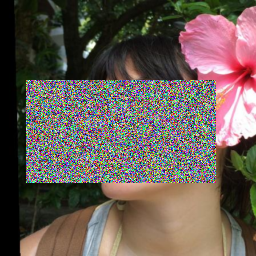

Epoch 001/050:   1%|          | 1/157 [00:01<02:58,  1.14s/it, loss=0.7200]

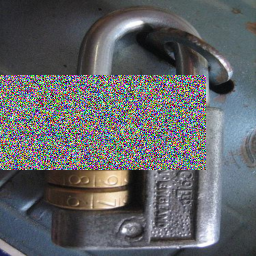

Epoch 001/050:   1%|▏         | 2/157 [00:01<01:45,  1.47it/s, loss=0.5825]

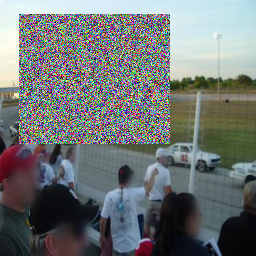

Epoch 001/050:   2%|▏         | 3/157 [00:01<01:26,  1.78it/s, loss=0.4712]

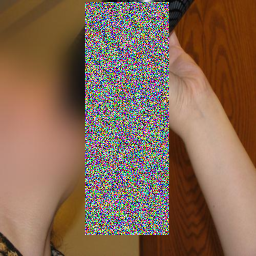

Evaluating:  92%|█████████▏| 79/86 [00:12<00:01,  6.26it/s]


KeyboardInterrupt: 

In [24]:
# Training loop
if not load_ckpt:
    start_time = time.time()

    rtpt = RTPT('DR', 'Train_Face_Detector', num_epochs)
    rtpt.start()

    print("\nInitiating experiment...")
    print(f"setup:\t\t{exp_setups[exp]}")
    print(f"model:\t\t{model_desc}")
    print(f"dataset:\t{dataset_desc}")
    print(f"lr:\t\t{lr}")
    print(f"trainset size:\t{size_train}")
    print(f"pretraining:\t{pretrained}")
    if do_noise_attack:
        print(f"attacks:\t{eps_attack}")
    print(f"device:\t\t{device}\n")


    for epoch in range(num_epochs):
        
        model.train()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {(epoch+1):03d}/{num_epochs:03d}")
        for batch_idx, (features, targets, _) in pbar:
            
            features = features.to(device)
            if occ_during_train:
                occlusions = generate_uniform_occ_batch_train(occ_mean_train)
                features = occlude_patch(features, occlusions)
                # visualize_image_from_torch(features[0])
            
            targets = targets.to(device)
            
                
            # forward and backward pass
            logits = model(features)
            targets_exp = F.one_hot(targets).float()
            loss = bin_ce(logits, targets_exp)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            run["train/loss"].append(loss.item())

            optimizer.zero_grad()
            
            loss.backward()
            
            # update model params 
            optimizer.step()
            
            
            # if batch_idx == 3:
            #     break


        if (epoch+1) in save_ckpt_after_epochs:
            ckpt_save_path = ckpt_dir + run["sys/id"].fetch() + "_" + str(epoch+1) + "_epochs.pt"
            
            torch.save({"model_state_dict": model.state_dict()}, ckpt_save_path)
            print(f"Saved checkpoint at: {ckpt_save_path}")
            
        model.eval()
        # with torch.set_grad_enabled(False): # save memory during inference
        evaluate_metrics(model, fool_model, val_loader, device, "valid", True)

        scheduler.step()
        rtpt.step()
        
    print(f"Total Training Time: {get_elapsed_time(start_time)}")   

In [ ]:
# evaluate experiment on test sets
# with torch.set_grad_enabled(False): # save memory during inference
print(f"\nEvaluation of experiment: '{exp_setups[exp]}'\n")

# evaluation CelebA
# total_acc, accs, MAD, rmsd_acc, total_f1, f1_scores, total_prec, precs, total_rec, recs = evaluate_metrics(model, fool_model, test_loader_celeb, device, "eval_celeb", show_tqdm=True)
# print("\nEvaluation CelebA test set:")
# print(f"Total accuracy: {total_acc:.2%}\t| Accuracies:\t{accs}")
# print(f"Maximum accuracy disparity: {MAD}")
# print(f"Total precision: {total_prec:.2%}\t| Precisions:\t{precs}")
# print(f"Total recall: {total_rec:.2%}\t| Recalls:\t{recs}\n")

# evaluation FairFace
model.eval()
total_robs, robs, _, _ = evaluate_metrics(model, fool_model, test_loader, device, "eval_ff", show_tqdm=True)
# print("\nEvaluation FairFace test set:")
# print(f"Total accuracy: {total_acc:.2%}\t| Accuracies:\t{accs}")
# print(f"Maximum accuracy disparity: {MAD}")
# print(f"Total precision: {total_prec:.2%}\t| Precisions:\t{precs}")
# print(f"Total recall: {total_rec:.2%}\t| Recalls:\t{recs}\n")

# print(f"Total robustnesses:{total_robs}")
# print(f"Robustnesses:{robs}")



Evaluation of experiment: 'original'



Evaluating: 100%|██████████| 86/86 [02:42<00:00,  1.89s/it]


In [ ]:
# # print(robs)
# if load_ckpt:
#     robustness_dir = "robustness_np_arrays"
#     if do_noise_attack:
#         gaussian_att = "_gaussian" if gaussian_attack else ""
#         file_path_total = f"{robustness_dir}/total_rob_{exp_num}_{smallest_eps}_{biggest_eps:.1e}_{eps_steps}_steps{gaussian_att}.npy"
#         file_path_races = f"{robustness_dir}/robs_{exp_num}_{smallest_eps}_{biggest_eps:.1e}_{eps_steps}_steps{gaussian_att}.npy"
#     if occ_during_val:
#         file_path_total = f"{robustness_dir}/occ/total_rob_{exp_num}_{smallest_occ}_{biggest_occ:.1e}_{occ_steps}_steps_R.npy"
#         file_path_races = f"{robustness_dir}/occ/robs_{exp_num}_{smallest_occ}_{biggest_occ:.1e}_{occ_steps}_steps_R.npy"
   
#     print(total_robs)
#     print(robs)
#     np.save(file_path_total, total_robs)
#     np.save(file_path_races, robs)
#     # print(np.load(file_path))

[1.     0.7936 0.5828]
[[1.     0.7001 0.3976]
 [1.     0.817  0.6127]
 [1.     0.8382 0.6171]
 [1.     0.8034 0.5282]
 [1.     0.8268 0.5972]
 [1.     0.8264 0.5966]
 [1.     0.7314 0.4619]
 [1.     0.7982 0.624 ]]
